In [1]:
# ! mkdir data
# ! mkdir data/palm_tree
# ! gsutil cp -r gs://nclinton-misc/high-res-patches data/palm_tree

In [65]:
STAGING_BUCKET = "ivanmkc-palm-data"

! gsutil mb gs://{STAGING_BUCKET}

Creating gs://ivanmkc-palm-data/...
ServiceException: 409 A Cloud Storage bucket named 'ivanmkc-palm-data' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [76]:
import tensorflow as tf

LABELS_SIZE = 8054

# Keys listed in go/sat-seg-keys.
palette = [
'000000', # 0 No Data
'a6cee3', # 1 Water
'1f78b4', # 2 Opaque Clouds
'b2df8a', # 3 Trees and Shrubs
'33a02c', # 4 Built surface
'fb9a99', # 5 Bridges and dams
'e31a1c', # 6 Grass
'fdbf6f', # 7 Plant/Ground Mix
'ff7f00', # 8 Crops (other than Palm Plantations)
'cab2d6', # 9 Palm Plantations
'6a3d9a', # 10 Flooded Vegetation
'ffff99', # 11 Bare Ground and Sand
'b15928', # 12 Snow and Ice
'000000'  # 13 Unknown
]

NUM_CLASSES = len(palette)

# Each tile is from 30cm WV3 satellite imagery, is 1024px x 1024px and is labelled twice.
SCALE = 0.3
PATCH_SIZE = 512

BANDS = ['R', 'G', 'B']
LABELS_NAMES = ['label_1', 'label_2']
FEATURES = BANDS + LABELS_NAMES

IMG_SIZE = [PATCH_SIZE, PATCH_SIZE, len(BANDS)]

# Specify the size and shape of patches expected by the model.
KERNEL_SHAPE = [PATCH_SIZE, PATCH_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(tensor):
  """Function to convert a tensor to a tuple of (inputs, outputs).
  Args:
    tensor: A stacked tensor, with label last.
  Returns:
    A tuple of (inputs, outputs).
  """
  return tensor[:,:,:len(BANDS)], tensor[:,:,len(BANDS):]


def flatten_patches(inputs):
  """Function to convert a dictionary of tensors to two stacked 
    tensors in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tf.data.Dataset with two examaples in it.
  """
  inputsList = [inputs.get(key) for key in BANDS]
  label_1 = [inputs.get(LABELS_NAMES[0])]
  label_2 = [inputs.get(LABELS_NAMES[1])]
  stack1 = tf.stack(inputsList + label_1, axis=0)
  stack2 = tf.stack(inputsList + label_2, axis=0)
  # Convert from CHW to HWC
  return tf.data.Dataset.from_tensor_slices([
    tf.transpose(stack1, [1, 2, 0]),
    tf.transpose(stack2, [1, 2, 0]),
  ])
  
def get_dataset(glob):
  """"""
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.flat_map(flatten_patches)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset


def get_datasets(pattern):
    """"""
    glob = tf.io.gfile.glob(pattern)
    size = len(glob)
    train_size = int(0.8*size)
    shuffled = tf.random.shuffle(glob)
    train_files = shuffled[:train_size]
    test_files = shuffled[train_size:]
    training = get_dataset(train_files)
    # training = training.shuffle(2048).repeat()
    testing = get_dataset(test_files)
    # testing = testing.batch(1)
    return training, testing

In [77]:
TRAINING_BASE = 'labels_'
FOLDER = 'high-res-patches'
BUCKET = 'nclinton-misc'

pattern = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'

training, testing = get_datasets(pattern)


In [5]:
import tensorflow_datasets as tfds

for i, (image, mask) in enumerate(tfds.as_numpy(training.take(1))):
    print(image.shape)
    print(mask.shape)

2022-04-27 21:53:55.709342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 273 of 2048
2022-04-27 21:54:06.731802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 405 of 2048
2022-04-27 21:54:15.986955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 633 of 2048
2022-04-27 21:54:25.785135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 819 of 2048
2022-04-27 21:54:35.707072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1079 of 2048
2022-04-27 21:54:52.909785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1271 of 2048
2022-04-27 21:55:01.955649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle

(512, 512, 3)
(512, 512, 1)


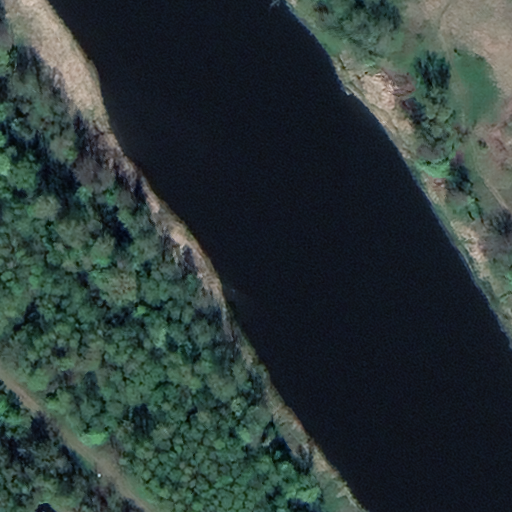

In [6]:
from PIL import Image
import numpy as np

image_object = Image.fromarray(np.uint8(image)).convert('RGB')
display(image_object)


In [7]:
# mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3))

# mask_rgb.shape

# mask_rgb[mask_rgb == 0] = [1, 2, 3]

In [10]:
# bmask_rgb[mask_rgb == 0]
import matplotlib.pyplot as plt

def display_image_mask(image, mask):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask']

  display_list = [image, mask]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

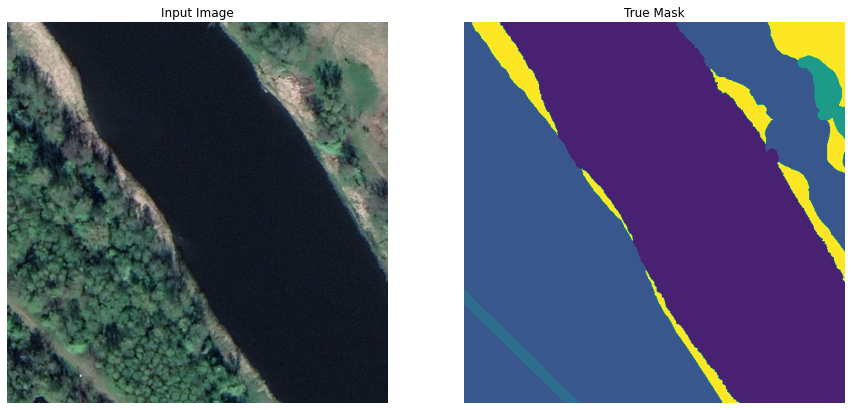

In [12]:
display_image_mask(image, mask)

In [59]:
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    destination_file_name = os.path.join(bucket_name, destination_blob_name)

    return destination_file_name
    # destination = os.path.join("/bigstore", bucket_name, destination_blob_name)
    # ! fileutil_bs cp -f {source_file_name} {destination}

In [127]:
from typing import Dict
import os
import hashlib

file_to_checksum_map: Dict[str, str] = {}

class ImageSegmentationConverter:
  def __init__(self, number_to_label_map: Dict[int, str]):
    import seaborn as sns

    self.number_to_label_map = number_to_label_map
    
    colors = [np.array(list(color))*255 for color in sns.color_palette(None, len(self.number_to_label_map))]
    self.number_to_color_map = {number: color for number, color in zip(number_to_label_map.keys(), colors)}

  # See https://docs.google.com/document/d/1rwdR0IKPCIU5Lw2lsuiN_s-FH6NCBByUtuBqZyBG9o8/edit#bookmark=id.u2hwzu97nn4o
  # See https://source.corp.google.com/piper///depot/google3/googlex/agility/agdata/ml/semantic_segmentation/data_preprocessor.py;bpv=1;bpt=1;rcl=388684767;l=148?gsn=decode_img_mask_from_tfexample&gs=kythe%3A%2F%2Fgoogle3%3Flang%3Dpython%3Fpath%3Dgooglex%2Fagility%2Fagdata%2Fml%2Fsemantic_segmentation%2Fdata_preprocessor.py%23module.Preprocessor.decode_img_mask_from_tfexample
  def convert_example_to_dict(self, image_np: np.ndarray, mask_np: np.ndarray, name: str, output_gcs_bucket: str, output_gcs_blob_folder: str, train_val_test: str, show_image: bool = True) -> Dict:
    # Create image
    image = tf.keras.utils.array_to_img(image_np)

    # Write to temp file
    temp_filename = "temp.png"
    image.save(temp_filename, format="png")

    # Create image mask matrix
    image_mask_matrix = mask_np.reshape(mask_np.shape[:2])
    # Rewrite as RGB
    image_mask_matrix_rgb = np.zeros((image_mask_matrix.shape[0], image_mask_matrix.shape[1], 3), dtype=np.uint8)
    numbers_used = set()
    for number in self.number_to_label_map.keys():
      color = self.number_to_color_map[number]
      if len(image_mask_matrix_rgb[..., :][image_mask_matrix==number]) > 0:
        image_mask_matrix_rgb[..., :][image_mask_matrix==number] = color
        numbers_used.add(number)
        
    # Convert back to image
    image_mask_rgb = Image.fromarray(image_mask_matrix_rgb)
    mask_filename = "mask.png"
    image_mask_rgb.save(mask_filename, format="png")

    # if show_image:      
    #   image_mask = Image.fromarray(np.uint8(image_mask_matrix>0)*255, mode="L")
      
    #   image = Image.open(BytesIO(image_encoded))
    #   image.paste(image_mask_rgb, (0, 0), image_mask)
    #   imshow(image)

    # Upload image to GCS
    output_gcs_blob_file = os.path.join(output_gcs_blob_folder, f"{name}.png")
    upload_blob(output_gcs_bucket, temp_filename, output_gcs_blob_file)

    # Upload mask to GCS
    mask_gcs_blob_file = os.path.join(output_gcs_blob_folder, f"{name}_mask.png")
    upload_blob(output_gcs_bucket, mask_filename, mask_gcs_blob_file)

    # Check for duplicates
    image_checksum = hashlib.md5(image_mask_rgb.tobytes()).hexdigest()
    if image_checksum in file_to_checksum_map:
      raise ValueError(f"Processing {name}, but duplicate image found in {file_to_checksum_map[image_checksum]}")
    else:
      file_to_checksum_map[image_checksum] = name

    mask_annotation = {
        "categoryMaskGcsUri": f"gs://{os.path.join(output_gcs_bucket, mask_gcs_blob_file)}",
        "annotationSpecColors": [
            {
                "color": {
                    "red": color[0]/255,
                    "green": color[1]/255,
                    "blue": color[2]/255,
                },
                "displayName": self.number_to_label_map[number]
            }
            for number, color in self.number_to_color_map.items()
            if number in numbers_used
          ]
    }

    return {
        "imageGcsUri": f"gs://{os.path.join(output_gcs_bucket, output_gcs_blob_file)}",
        "segmentationAnnotation": mask_annotation,
        "dataItemResourceLabels": {
          "aiplatform.googleapis.com/ml_use": train_val_test
        }
    }

In [128]:
image_segmentation_converter = ImageSegmentationConverter(number_to_label_map={
        0: "nodata",
        1: "water",
        2: "opaqueclouds",
        3: "treesandshrubs",
        4: "builtsurface",
        5: "bridgesanddams",
        6: "grass",
        7: "plantgroundmix",
        8: "crops",
        9: "palmplantations",
        10: "floodedvegetation",
        11: "baregroundandsand",
        12: "snowandice",
        13: "unknown",
    }
)

In [129]:
import uuid
output_gcs_blob_folder = "palm-tree-data"

image_dicts = []
for i, (image_np, mask_np) in enumerate(tfds.as_numpy(training)):
    print(f"Processing: {i}")
    image_dicts.append(
        image_segmentation_converter.convert_example_to_dict(
            image_np=image_np, 
            mask_np=mask_np, 
            name=uuid.uuid4(),
            output_gcs_bucket=STAGING_BUCKET, 
            output_gcs_blob_folder=output_gcs_blob_folder, 
            train_val_test="train"
        )
    )

Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9
Processing: 10
Processing: 11
Processing: 12
Processing: 13
Processing: 14
Processing: 15
Processing: 16
Processing: 17
Processing: 18
Processing: 19
Processing: 20
Processing: 21
Processing: 22
Processing: 23
Processing: 24
Processing: 25
Processing: 26
Processing: 27
Processing: 28
Processing: 29
Processing: 30
Processing: 31
Processing: 32
Processing: 33
Processing: 34
Processing: 35
Processing: 36
Processing: 37
Processing: 38
Processing: 39
Processing: 40
Processing: 41
Processing: 42
Processing: 43
Processing: 44
Processing: 45
Processing: 46
Processing: 47
Processing: 48
Processing: 49
Processing: 50
Processing: 51
Processing: 52
Processing: 53
Processing: 54
Processing: 55
Processing: 56
Processing: 57
Processing: 58
Processing: 59
Processing: 60
Processing: 61
Processing: 62
Processing: 63
Processing: 64
Processing: 65
Processing: 66
Proce

ValueError: Processing 28079731-c5fe-42ca-86e0-67900645c343, but duplicate image found in 93b1bdc9-140f-4ffa-898c-43a75ba554ab

In [ ]:
import json

JSONL_FILENAME = "palm_image_annotations.jsonl"

# Write annotations
with open(JSONL_FILENAME, 'w') as outfile:
    for entry in image_dicts:
        # print(entry)
        json.dump(entry, outfile)
        outfile.write('\n')


In [ ]:
JSONL_FILENAME_GCS = f"gs://{STAGING_BUCKET}/{JSONL_FILENAME}"

! gsutil cp {JSONL_FILENAME} {JSONL_FILENAME_GCS}

Copying file://palm_image_annotations.jsonl [Content-Type=application/octet-stream]...
/ [1 files][ 12.1 KiB/ 12.1 KiB]                                                
Operation completed over 1 objects/12.1 KiB.                                     


In [ ]:
from google.cloud import aiplatform

aiplatform.init()

DATASET_DISPLAY_NAME = F"palm_{uuid.uuid4()}"
# existing = aiplatform.ImageDataset(dataset_name=DATASET_NAME)
# existing.delete()

dataset = aiplatform.ImageDataset.create(display_name=DATASET_DISPLAY_NAME, gcs_source=JSONL_FILENAME_GCS, import_schema_uri=aiplatform.schema.dataset.ioformat.image.image_segmentation)

INFO:google.cloud.aiplatform.datasets.dataset:Creating ImageDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create ImageDataset backing LRO: projects/580378083368/locations/us-central1/datasets/7110458133943681024/operations/4707544259635445760
INFO:google.cloud.aiplatform.datasets.dataset:ImageDataset created. Resource name: projects/580378083368/locations/us-central1/datasets/7110458133943681024
INFO:google.cloud.aiplatform.datasets.dataset:To use this ImageDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.ImageDataset('projects/580378083368/locations/us-central1/datasets/7110458133943681024')
INFO:google.cloud.aiplatform.datasets.dataset:Importing ImageDataset data: projects/580378083368/locations/us-central1/datasets/7110458133943681024
INFO:google.cloud.aiplatform.datasets.dataset:Import ImageDataset data backing LRO: projects/580378083368/locations/us-central1/datasets/7110458133943681024/operations/1861269295137292288
INFO:google.clo

In [86]:
mask_on_file = Image.open("20933c8b-456e-41e1-b49f-7ff067cb890f_mask.png")

In [96]:
mask_as_floats = np.asarray(mask_on_file)/255

In [98]:
mask_as_floats.shape

(512, 512, 3)

In [99]:
np.unique(
        mask_as_floats.view(np.dtype((np.void, mask_as_floats.dtype.itemsize*mask_as_floats.shape[2])))
        ).view(mask_as_floats.dtype).reshape(-1, mask_as_floats.shape[2])


array([[1.        , 0.49803922, 0.05490196],
       [0.58039216, 0.40392157, 0.74117647]])